# PlotResults.ipynb
### example notebook demonstrating how to plot and inspect simulation outputs
### contains all plots of Section 4.1 in the publication

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-notebook')

In [2]:
plt.rcParams.update({'xtick.labelsize':13,'ytick.labelsize':13})

In [3]:
PLOTPATH ='/global/homes/v/vboehm/codes/MADLens/figures' 

In [4]:
from MADLens.util import *

### load halofit sensitivity analysis

In [5]:
# procomputed Halofit accuracy
out = np.load(os.path.join(PLOTPATH,'boosts-3.npz'))

In [6]:
from scipy.interpolate import interp1d
DeltaCL = interp1d(np.logspace(0,4,1000),(out['upper']-out['lower'])/2)

### list all possible run files

In [7]:
# run_dir   = '../runs'

# githashes = os.listdir(run_dir)
# for githash in githashes:
#     print(githash)
#     path = os.path.join(run_dir,githash)
#     print(os.listdir(path))

### plot function

In [8]:
def plot(z1_runs, boxsizes, interps, zss, labels, name, noise=None, other = True, other_label=[''], nplots=2, Ns=[100.], fsky =0.1, halofit_uncert=False, shape_noise=False, subtract_noise=True):
    
    colors = ['royalblue','mediumseagreen','coral']
    colors2= ['darkblue','darkgreen', 'firebrick']
    if nplots == 2:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(2,1)})
    elif nplots ==1:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=True, figsize=(8,4))
        ax = [ax]
    else:
        raise ValueError('number of plots not supported')
        
    
    
    for jj, zs in enumerate(np.unique(zss)):
        interp=interps[0]
        boxsize=str(boxsizes[0])
        L    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['L']
        x    = L*(L+1)/np.pi/2.
        yt   = z1_runs[boxsize][interp][str(zs)].theory_cls[str(zs)]['clkk']

        if len(np.unique(zss))==1:
            ax[0].loglog(L,x*yt, label='HaloFit', color=colors2[jj])
        else:
            ax[0].loglog(L,x*yt, color=colors2[jj])
            
        if other:
            z    = z1_runs[boxsize][interp][str(zs)].other_cls[str(zs)]['clkk']
            ax[0].loglog(L,x*z, label=other_label, color='gray')
        
    for ii, (boxsize, interp, zs, label) in enumerate(zip(boxsizes,interps,zss, labels)):

        boxsize=str(boxsize)
        print(boxsize, interp, zs, label)

        L    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['L']
        x    = L*(L+1)/np.pi/2.
        y    = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['clkk']
        if subtract_noise is True:
            try:
                assert(noise is not None)
                y_ = y - noise
                ax[0].loglog(L,x*y_, label='MADLens, sn subtracted', color='deepskyblue')
            except:
                raise ValueError('noise must be specified for subtraction')
                
        yerr = z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['clkk_std']/z1_runs[boxsize][interp][str(zs)].measured_cls[str(zs)]['N']
        yt   = z1_runs[boxsize][interp][str(zs)].theory_cls[str(zs)]['clkk']

        
#         if len(np.unique(zss))==1:
#             ax[0].set_title('$z_{source}$=%.1f'%zs,fontsize=16)
        
        if len(np.unique(zss))>1:
            ax[0].loglog(L,x*y, label='MADLens%s, $z_s=$%.1f'%(label,zs), color=colors[ii])
        elif len(np.unique(boxsizes))>1:
            ax[0].loglog(L,x*y, label='MADLens%s, %s Mpc/h'%(label,boxsize), color=colors[ii])
        else:
            ax[0].loglog(L,x*y, label='MADLens%s'%(label), color=colors[ii])
        
        if halofit_uncert:
            ind =np.where(L<=10000)
            LL = L[ind]
            xx = LL*(LL+1.)/2./np.pi
            ax[0].fill_between(LL, xx*(yt[ind]-DeltaCL(LL)), xx*(yt[ind]+DeltaCL(LL)),color='gray', label='HaloFit accuracy', alpha=0.2, zorder=--1)
        
        if noise is not None:
            noise_smooth = np.convolve(noise,np.ones(20)/20., mode='same')
            ax[0].loglog(L,x*noise, label='measured shot noise (sn)', color='dimgray')
            
        if ii ==len(zss)-1:
            lss = ['-.','--']
            for ls, N in enumerate(Ns):
                Cl_shape = compute_shape_noise_power(sigma_e=0.4,n=N,fsky=fsky)
                Cl_shape*=(np.pi/(180.*60.))**2
                ax[0].loglog(L,x*Cl_shape, label='shape noise $n{=}$%d$\mathrm{arcmin}^{-2}$, $f_{sky}{=}$%.1f'%(N,fsky), color='rosybrown', ls=lss[ls])  
        
        handles, labels = ax[0].get_legend_handles_labels()
        
        ratio = (y-yt)/yt
        if subtract_noise:
            ratio_= (y_-yt)/yt
        ratio_error = (yerr)/yt 
        if nplots>1:
            ax[1].semilogx(L,ratio, color=colors[ii])
            if subtract_noise:
                ax[1].semilogx(L,ratio_, color='deepskyblue')
            ax[1].fill_between(L,ratio-ratio_error, ratio+ratio_error,color='gray', alpha=0.2)
            if shape_noise and ii ==len(zss)-1:
                ax[1].fill_between(L, -Cl_shape/yt, Cl_shape/yt,color='rosybrown', alpha=0.2)
            if halofit_uncert:
                ind =np.where(L<=10000)
                LL = L[ind]
                ax[1].fill_between(LL, (-DeltaCL(LL))/yt[ind], (+DeltaCL(LL))/yt[ind],color='gray', alpha=0.2)
                ax[1].set_ylim(-0.30,0.30)
            else:
                ax[1].set_ylim(-0.15,0.15)
            ax[1].set_ylabel('relative difference')
            ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)
            ax[1].set_xlabel('$L$',fontsize=16)
        else:
            ax[0].set_xlabel('$L$',fontsize=16)
        
        ax[0].set_ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
        
        if boxsize == '512':
            ax[0].set_xlim(100,10000)
            ax[0].set_ylim(5e-5/2./np.pi,5e-3/2./np.pi)
        else:
            ax[0].set_xlim(200,10000)
            ax[0].set_ylim(2e-5/2./np.pi,1e-2/2./np.pi)
            
    if np.any(noise==None):
        offset = len(Ns)
    else:
        offset = len(Ns)+2
        
    if len(np.unique(zss))>1:
        first_legend = ax[0].legend(handles=handles[-offset::], loc='lower right',fontsize=14,framealpha=0.95)
    else:
        first_legend = ax[0].legend(handles=handles[-offset::], loc='lower left',fontsize=14,framealpha=0.95)

    # Add the legend manually to the current Axes.
    #ax_ = plt.gca().add_artist(first_legend)
    ax[0].add_artist(first_legend) 
    if len(np.unique(zss))>1:
        sec_legend = ax[0].legend(handles=handles[:-offset][::-1],fontsize=14,ncol=1,framealpha=0.99, loc='upper left')
        ax[0].add_artist(sec_legend) 
    else:
        sec_legend = ax[0].legend(handles=handles[:-offset][::-1],fontsize=14,ncol=1,framealpha=0.99, loc='upper left')
        ax[0].add_artist(sec_legend) 
    if nplots>1:
        ax[1].grid()
    plt.savefig(os.path.join(PLOTPATH,'%s.pdf'%name),bbox_inches='tight')
    plt.show()

In [9]:
# create dict of runs
boxsizes        = [1024,512,256,128]
interpolations  = ['interp', 'no_interp']
specials        = ['highres', '11step']
redshifts       = ['0.8', '1.0', '1.2']

runs={}
for boxsize in boxsizes:
    runs[str(boxsize)]={}
    for interp in interpolations:
        runs[str(boxsize)][interp]={}
        for special in specials:
            runs[str(boxsize)][interp][special]={}

### White noise and HaloFit accuracy comparison

In [10]:
run = Run(githash='0dc860f', label='whitenoise', rnum=0, local_path='../')
run.fill_cl_dicts(downsample=False)
white_noise = run.measured_cls['1.0']['clkk']

white_map = run.get_map(1.,0)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD False and interpolation False.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....
Loading map 0 of 5...


In [11]:
run = Run(githash='e18db0b', label='cross_test', rnum=0, local_path='../')
runs['256']['no_interp']['1.0']=run
runs['256']['no_interp']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

256 no_interp 1.0 


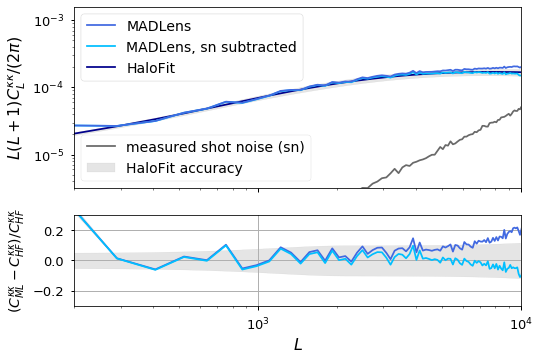

In [12]:
plot(runs, boxsizes=[256], interps=['no_interp'], zss=[1.0], labels=[''],other=False, other_label='integrated measured $P_k$', noise=white_noise, nplots=2, name='int_comp', Ns=[],halofit_uncert=True, subtract_noise=True)
# match to tail of green line

### Redhsift comparisons

In [13]:
run = Run(githash='859f754', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 0.80, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


In [14]:
run = Run(githash='5913840', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


In [15]:
run = Run(githash='a349dc9', label='transfer_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
run.fill_cl_dicts(downsample=False)

if run.params['interpolate']:
    runs[str(int(run.params['BoxSize'][0]))]['interp'][str(run.params['zs_source'][0])]=run
else:
    runs[str(int(run.params['BoxSize'][0]))]['no_interp'][str(run.params['zs_source'][0])]=run

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.20, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


512 interp 0.8 
512 interp 1.0 
512 interp 1.2 


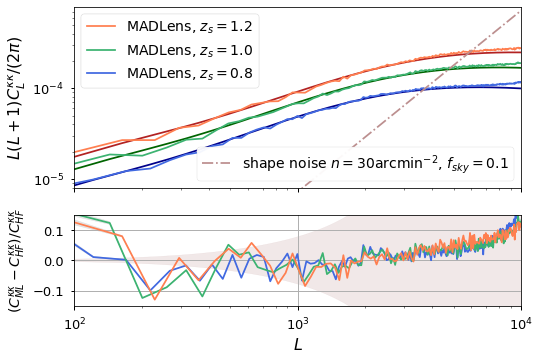

In [16]:
plot(runs, boxsizes=[512, 512, 512], interps=['interp','interp','interp'], zss=[0.8, 1.0, 1.2], other=False,labels=['','',''], name='redshift_comp', Ns=[30], shape_noise=True, subtract_noise=False)

### High resolution run comparisons

In [17]:
run = Run(githash='32896b0', label='cross_test', rnum=0, local_path='../')
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
#run.fill_cl_dicts(downsample=False)
map_highres = run.get_map(1.,0)
comp_map = runs['512']['interp']['1.0'].get_map(1.,0)

Loading run with BoxSize 512, Nmesh 1024, SourceRedshift 1.00, PGD False and interpolation True.
1 maps were produced in this run
Loading map 0 of 1...
Loading map 0 of 5...


In [18]:
# run = Run(githash='211ec75', label='cross_test', rnum=0, local_path='../')
# map_highres_05 = run.get_map(0.5,0)
run = Run(githash='0d2350a', label='cross_test', rnum=0, local_path='../')
comp_map_noPGD = run.get_map(1.0,0)

Loading run with BoxSize 512, Nmesh 512, SourceRedshift 1.00, PGD False and interpolation True.
1 maps were produced in this run
Loading map 0 of 1...


/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


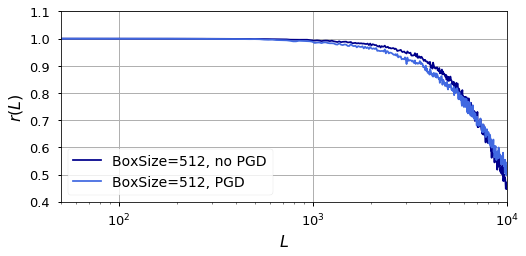

In [21]:
cross_power = FFTPower(first=map_highres,second=comp_map, mode='1d').power
cross_power2 = FFTPower(first=map_highres,second=comp_map_noPGD, mode='1d').power
power1 = FFTPower(first=comp_map,second=comp_map, mode='1d').power
power2 = FFTPower(first=map_highres,second=map_highres, mode='1d').power
power3 = FFTPower(first=comp_map_noPGD,second=comp_map_noPGD, mode='1d').power
# comparison with no PGD
# cross_power_05 = FFTPower(first=map_highres_05,second=comp_map_05, mode='1d').power
# power1_05 = FFTPower(first=comp_map_05,second=comp_map_05, mode='1d').power
# power2_05 = FFTPower(first=map_highres_05,second=map_highres_05, mode='1d').power

plt.figure(figsize=(8,3.5))
plt.plot(cross_power['k'],abs(cross_power2['power'])/abs(np.sqrt(power3['power']*power2['power'])),color='darkblue', label='BoxSize=512, no PGD')
plt.semilogx(cross_power['k'],abs(cross_power['power'])/abs(np.sqrt(power1['power']*power2['power'])),color='royalblue', label='BoxSize=512, PGD')
plt.xlabel('$L$',fontsize=16)
plt.ylabel('$r(L)$',fontsize=16)
plt.xlim(50,1e4)
plt.ylim(0.4,1.1)
plt.legend(fontsize=14)
plt.grid()
plt.savefig(os.path.join(PLOTPATH,'cross_corr.pdf'),bbox_inches='tight')
plt.show()

Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....
Loading map 0 of 5...


/global/homes/v/vboehm/.conda/envs/fwdmodel/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


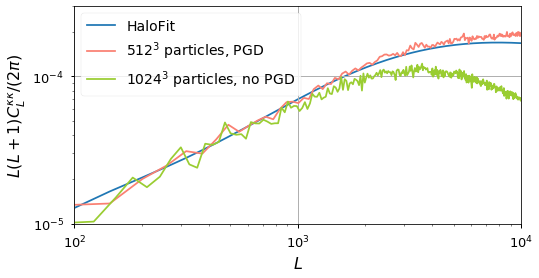

In [22]:
plt.figure(figsize=(8,4))
l= cross_power['k']
halofit = runs['512']['interp']['1.0'].theory_cls['1.0']['clkk']
LL = runs['512']['interp']['1.0'].theory_cls['1.0']['L']

runs['512']['interp']['1.0'].fill_cl_dicts(downsample=False)
pp = runs['512']['interp']['1.0'].get_map(1.0,0)
L, pp, _ = get_2Dpower(pp)

plt.loglog(LL,LL*(LL+1)/2./np.pi*halofit, label='HaloFit', zorder=-1)
plt.loglog(L,L*(L+1)/2./np.pi*pp,label='$512^3$ particles, PGD', color='salmon')
plt.loglog(l,l*(l+1)/2./np.pi*power2['power'],label='$1024^3$ particles, no PGD', color='yellowgreen')

plt.xlim(100,1e4)
plt.ylim(1e-5,3e-4)
plt.ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
plt.xlabel('$L$',fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.savefig(os.path.join(PLOTPATH,'PGD_Cls.pdf'),bbox_inches='tight')

### Convergence map and histogram

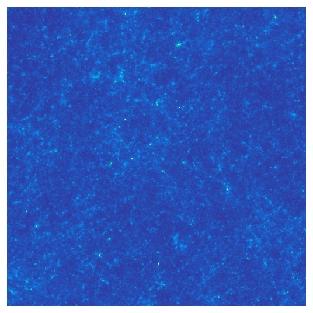

In [30]:
real_map = runs['256']['interp']['1.0'].get_map(1.0,0)
plt.imshow(downsample_map(real_map,512,runs['256']['interp']['1.0'].params), cmap='terrain')
plt.axis('off')
plt.savefig(os.path.join(PLOTPATH,'lensing_map.pdf'),bbox_inches='tight')

In [570]:
import scipy.optimize as optimize

def loss(x):
    a, b = x
    pdf = lognorm(s=np.exp(a), scale=np.exp(b))
    x = (bins[1][1:]+bins[1][:-1])/2.
    loss = np.sum((bins[0]-pdf.pdf(x))**2)
    return loss

result = optimize.minimize(loss,[0,0],method='Powell')
print(result)
print(np.exp(result['x']))

0.2401155837472853 0.06392504841559664


In [592]:
pdf_fit = lognorm(s=np.exp(result['x'])[0], scale =np.exp(result['x'])[1])

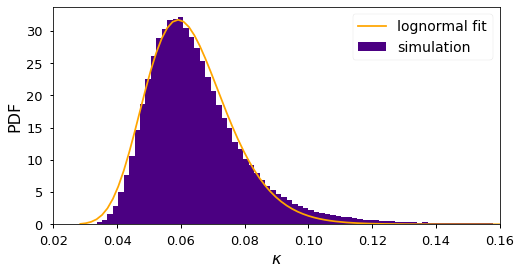

In [593]:
plt.figure(figsize=(8,4))
bins = plt.hist(downsample_map(real_map,512,runs['256']['interp']['1.0'].params).value.flatten(), bins=500, color='indigo', density=True, label='simulation')
plt.plot(bins[1],pdf_fit.pdf(bins[1]),label='lognormal fit',color='orange')
plt.xlim(0.02, 0.16)
plt.xlabel('$\kappa$', fontsize=16)
plt.ylabel('PDF', fontsize=16)
plt.legend(fontsize=14)
plt.savefig(os.path.join(PLOTPATH,'histogram.pdf'),bbox_inches='tight')

### Sub evolution plot

In [17]:
run = Run(githash='87b9348', label='cross_test', rnum=0, local_path='../')
runs['256']['interp']['11step']['1.0']=run
runs['256']['interp']['11step']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

In [24]:
run = Run(githash='1bfb819', label='cross_test', rnum=0, local_path='../')
runs['256']['interp']['1.0']=run
runs['256']['interp']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation True.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

In [19]:
run = Run(githash='e18db0b', label='cross_test', rnum=0, local_path='../')
runs['256']['no_interp']['1.0']=run
runs['256']['no_interp']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

In [20]:
run = Run(githash='73d941c', label='cross_test', rnum=0, local_path='../')
runs['256']['no_interp']['11step']['1.0']=run
runs['256']['no_interp']['11step']['1.0'].fill_cl_dicts(downsample=False)

Loading run with BoxSize 256, Nmesh 256, SourceRedshift 1.00, PGD True and interpolation False.
5 maps were produced in this run
Measuring Cls...
Loading map 0 of 5...
Loading map 1 of 5...
Loading map 2 of 5...
Loading map 3 of 5...
Loading map 4 of 5...
Computing theory Cls....


True

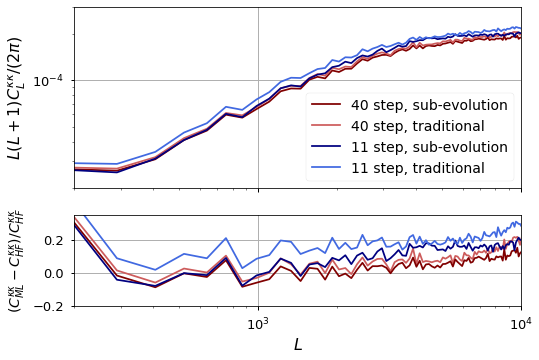

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, gridspec_kw={'height_ratios':(2,1)})

LL= runs['256']['no_interp']['1.0'].measured_cls['1.0']['L']
x = LL*(LL+1.)/2./np.pi
halofit = runs['256']['interp']['1.0'].theory_cls['1.0']['clkk']
p1= ax[0].loglog(LL,x*runs['256']['interp']['1.0'].measured_cls['1.0']['clkk'], label='40 step, sub-evolution', color='maroon')

p3=ax[0].loglog(LL,x*runs['256']['no_interp']['1.0'].measured_cls['1.0']['clkk'], label='40 step, traditional', ls ='-', color='indianred')
p2=ax[0].loglog(LL,x*runs['256']['interp']['11step']['1.0'].measured_cls['1.0']['clkk'], label='11 step, sub-evolution', color='navy')
p4=ax[0].loglog(LL,x*runs['256']['no_interp']['11step']['1.0'].measured_cls['1.0']['clkk'], label='11 step, traditional',color='royalblue')

#plt.loglog(LL,x*halofit, label='halofit')
ax[0].set_xlim(200,1e4)
ax[0].set_ylim(2e-5,3e-4)
ax[0].set_ylabel('$L(L+1) C^{\kappa \kappa}_L/(2\pi)$',fontsize=16)
ax[1].set_xlabel('$L$',fontsize=16)
ax[0].legend(fontsize=14)
ax[0].grid()
ref = halofit#runs['256']['interp']['1.0'].measured_cls['1.0']['clkk']

ax[1].semilogx(LL,(runs['256']['no_interp']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p3[0].get_color(), ls='-')
ax[1].semilogx(LL,(runs['256']['interp']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p1[0].get_color())
ax[1].semilogx(LL,(runs['256']['interp']['11step']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p2[0].get_color())
ax[1].semilogx(LL,(runs['256']['no_interp']['11step']['1.0'].measured_cls['1.0']['clkk']-ref)/ref, color=p4[0].get_color(), ls='-')
ax[1].set_ylabel(r'$(C_{ML}^{\kappa \kappa}-C_{HF}^{\kappa \kappa})/C_{HF}^{\kappa \kappa}$',fontsize=14)
ax[1].set_ylim(-0.2,0.35)
ax[1].grid()
plt.savefig(os.path.join(PLOTPATH,'Interp_Cls.pdf'),bbox_inches='tight')
plt.show()
# different framing

### Derivative Test

In [47]:
run = Run(githash='5861f3e', label='deriv_test_1_jvp', rnum=0, local_path='../')
map_new = run.get_map(1.0,0)

run = Run(githash='0e7cdb9', label='cross_test', rnum=0, local_path='../')
map_old = run.get_map(1.0,0)

Loading run with BoxSize 256, Nmesh 64, SourceRedshift 1.00, PGD False and interpolation False.
2 maps were produced in this run
Loading map 0 of 2...
Loading run with BoxSize 256, Nmesh 64, SourceRedshift 1.00, PGD False and interpolation False.
1 maps were produced in this run
Loading map 0 of 1...


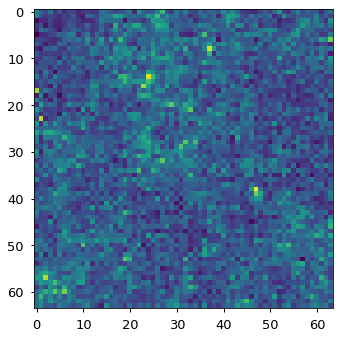

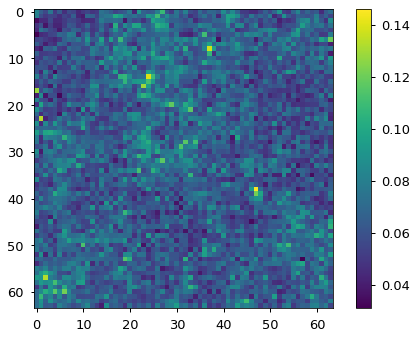

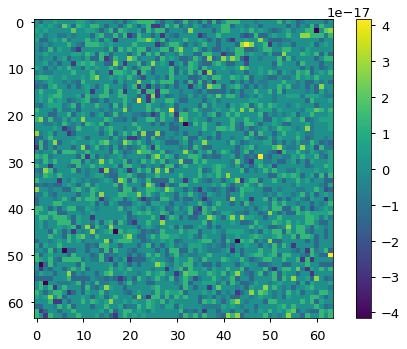

In [48]:
plt.imshow(map_new.value.reshape(64,64))
plt.show()
plt.imshow(map_old.value.reshape(64,64))
plt.colorbar()
plt.show()

plt.imshow(map_old.value.reshape(64,64)-map_new.value.reshape(64,64))
plt.colorbar()

### Derivative Tests without Interpolation

In [88]:
jvp  = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/d91b2c7/deriv_test_jvp0/maps/jvp_zsource10_map0_of1.npy')
map_ = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/d91b2c7/deriv_test_jvp0/maps/map_decon_zsource10_map0_of1.npy')

map_minus = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/d91b2c7/deriv_test_minus0/maps/map_decon_zsource10_map0_of1.npy')
map_plus = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/d91b2c7/deriv_test_plus0/maps/map_decon_zsource10_map0_of1.npy')

mapdiff = (map_plus-map_minus).reshape(64,64)

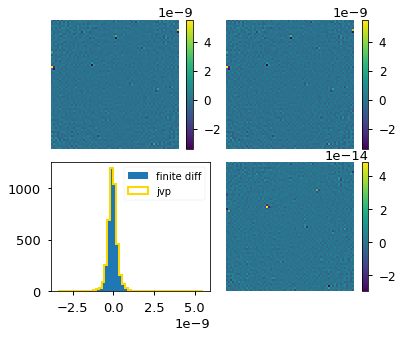

In [129]:
fig,ax = plt.subplots(2,2, figsize=(6,5))
im1 = ax[0][0].imshow((jvp).reshape(64,64), aspect="auto")
ax[0][0].axis('off')
cbar=fig.colorbar(im1, ax=ax[0, 0])
cbar.ax.tick_params(labelsize=12)
im2 = ax[0][1].imshow((mapdiff).reshape(64,64), aspect="auto")
ax[0][1].axis('off')
cbar = fig.colorbar(im2, ax=ax[0, 1])
cbar.ax.tick_params(labelsize=12)
im3 = ax[1][1].imshow(jvp.reshape(64,64)-mapdiff, aspect="auto")
ax[1][1].axis('off')
cbar = fig.colorbar(im3, ax=ax[1, 1])
cbar.ax.tick_params(labelsize=12)
_ =ax[1][0].hist((map_plus-map_minus).flatten(),bins=50, label='finite diff')
_ =ax[1][0].hist(jvp.flatten(),bins=50, alpha=1, label='jvp', histtype=u'step', lw=2, color='gold')
ax[1][0].legend()
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.savefig(os.path.join(PLOTPATH,'vjp_nointerp.pdf'),bbox_inches='tight')

### Derivative Tests with Interpolation

In [130]:
#636439a
jvp  = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/636439a/deriv_test_jvp0/maps/jvp_zsource10_map0_of1.npy')
map_ = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/636439a/deriv_test_jvp0/maps/map_decon_zsource10_map0_of1.npy')

map_minus = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/636439a/deriv_test_minus0/maps/map_decon_zsource10_map0_of1.npy')
map_plus = np.load('/global/cscratch1/sd/vboehm/MADLensOutputs/636439a/deriv_test_plus0/maps/map_decon_zsource10_map0_of1.npy')

mapdiff = (map_plus-map_minus).reshape(64,64)

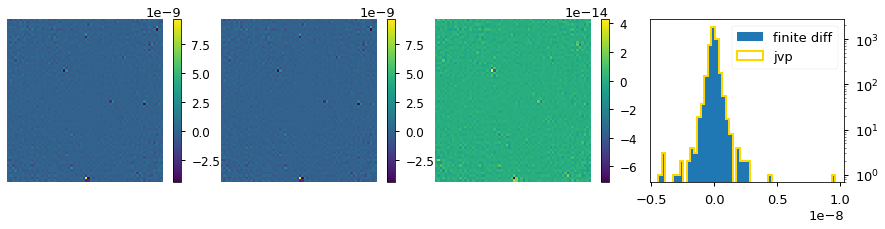

In [141]:
fig,ax = plt.subplots(1,4, figsize=(15,3))
im1 = ax[0].imshow((jvp).reshape(64,64), aspect="auto")
ax[0].axis('off')
cbar=fig.colorbar(im1, ax=ax[0])
cbar.ax.tick_params(labelsize=12)
im2 = ax[1].imshow((mapdiff).reshape(64,64), aspect="auto")
ax[1].axis('off')
cbar = fig.colorbar(im2, ax=ax[1])
cbar.ax.tick_params(labelsize=12)
im3 = ax[2].imshow(jvp.reshape(64,64)-mapdiff, aspect="auto")
ax[2].axis('off')
cbar = fig.colorbar(im3, ax=ax[2])
cbar.ax.tick_params(labelsize=12)
_ =ax[3].hist((map_plus-map_minus).flatten(),bins=50, label='finite diff', log=True)
_ =ax[3].hist(jvp.flatten(),bins=50, alpha=1, label='jvp', histtype=u'step', lw=2, color='gold')
ax[3].legend(fontsize=13)
ax[3].yaxis.tick_right()
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.savefig(os.path.join(PLOTPATH,'vjp_interp.pdf'),bbox_inches='tight')